# Importações

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

from sklearn.preprocessing import StandardScaler as Scaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

%matplotlib inline

plt.rcParams["figure.figsize"] = (16,10)

# Configurar dataset

### Baixar dados 

In [2]:
!wget -O fraud.csv https://www.dropbox.com/s/47hd95t7n8hhlgz/fraude.csv?dl=0

--2021-08-24 20:54:32--  https://www.dropbox.com/s/47hd95t7n8hhlgz/fraude.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6027:18::a27d:4812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/47hd95t7n8hhlgz/fraude.csv [following]
--2021-08-24 20:54:32--  https://www.dropbox.com/s/raw/47hd95t7n8hhlgz/fraude.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9ddec3ce0f26eda27283c7a946.dl.dropboxusercontent.com/cd/0/inline/BU3Fnk7k7MTG8ynJJUa8nA-sIhJYJB3560ljXcM_8qGs-9Ts_fGmFI1fH2zHj5WW9ooLvacA4_cwAo15M4DM0cds8y20zy6bvOST67xN6GOvxxPyt0EGB0Tk2XOq51XOM66DlUqd8OBqFbQ__rPD68sP/file# [following]
--2021-08-24 20:54:33--  https://uc9ddec3ce0f26eda27283c7a946.dl.dropboxusercontent.com/cd/0/inline/BU3Fnk7k7MTG8ynJJUa8nA-sIhJYJB3560ljXcM_8qGs-9Ts_fGmFI1fH2zHj5WW9ooLvacA4_cwAo15M4DM0cds

In [3]:
dataset_path = "fraud.csv"

### Ler CSV

In [4]:
df = pd.read_csv(dataset_path) 

# 3 - Preparação dos dados

## 3.1 - Normalização logarítimica

In [5]:
df['amount'].describe()

count    6.362620e+06
mean     1.798619e+05
std      6.038582e+05
min      0.000000e+00
25%      1.338957e+04
50%      7.487194e+04
75%      2.087215e+05
max      9.244552e+07
Name: amount, dtype: float64

In [6]:
df['oldbalanceOrg'].describe()

count    6.362620e+06
mean     8.338831e+05
std      2.888243e+06
min      0.000000e+00
25%      0.000000e+00
50%      1.420800e+04
75%      1.073152e+05
max      5.958504e+07
Name: oldbalanceOrg, dtype: float64

In [7]:
df['newbalanceOrig'].describe()

count    6.362620e+06
mean     8.551137e+05
std      2.924049e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.442584e+05
max      4.958504e+07
Name: newbalanceOrig, dtype: float64

In [8]:
df['oldbalanceDest'].describe()

count    6.362620e+06
mean     1.100702e+06
std      3.399180e+06
min      0.000000e+00
25%      0.000000e+00
50%      1.327057e+05
75%      9.430367e+05
max      3.560159e+08
Name: oldbalanceDest, dtype: float64

In [9]:
df['newbalanceDest'].describe()

count    6.362620e+06
mean     1.224996e+06
std      3.674129e+06
min      0.000000e+00
25%      0.000000e+00
50%      2.146614e+05
75%      1.111909e+06
max      3.561793e+08
Name: newbalanceDest, dtype: float64

Todos tem como valor mínimo 0. log 0 é impossível, logo deve-se mudar os valores para retirar o 0 antes de mudar a escala para logarítmica.

In [10]:
log_list = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

for i in log_list:
    df[i] = (0.1+df[i])#Como existem valores iguais a 0, é preciso tirá-los para fazer o log
    df[i] = np.log(df[i])

## 3.2 - Padronização dos dados
Apenas variáveis contínuas e discretas devem ser padronizadas.

In [11]:
colunas_x_scaler = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
scaler = Scaler()

df[colunas_x_scaler] = scaler.fit_transform(df[colunas_x_scaler])

In [12]:
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,-0.907025,C1231006815,0.807207,1.064841,M1979787155,-1.149416,-1.253358,0,0
1,1,PAYMENT,-1.823428,C1666544295,0.495724,0.780990,M2044282225,-1.149416,-1.253358,0,0
2,1,TRANSFER,-3.107899,C1305486145,-0.217747,-0.854877,C553264065,-1.149416,-1.253358,1,0
3,1,CASH_OUT,-3.107899,C840083671,-0.217747,-0.854877,C38997010,0.408776,-1.253358,1,0
4,1,PAYMENT,-0.813131,C2048537720,0.596146,0.839157,M1230701703,-1.149416,-1.253358,0,0
5,1,PAYMENT,-1.033743,C90045638,0.634985,0.897226,M573487274,-1.149416,-1.253358,0,0
6,1,PAYMENT,-1.086189,C154988899,0.818280,1.077465,M408069119,-1.149416,-1.253358,0,0
7,1,PAYMENT,-1.030656,C1912850431,0.812355,1.071328,M633326333,-1.149416,-1.253358,0,0
8,1,PAYMENT,-1.399541,C1265012928,0.185208,-0.854877,M1176932104,-1.149416,-1.253358,0,0
9,1,DEBIT,-1.243950,C712410124,0.596743,0.865586,C195600860,0.495441,0.405884,0,0


## 3.3 - Separação dos dados
É preciso separar os dados em treino, teste e validação antes de normalizar os dados, caso contrário ocorrerá vazamento de dados.
60% dos dados serão usados no grupo de treinamento, 25% no grupo de validação e 15% no grupo de teste.

### 3.3.1 - Separa em treino, teste e validacao

In [13]:
tamanho_df = df.shape[0]
colunas_y = ["isFraud"]
colunas_nao_x = ["isFraud", "isFlaggedFraud"]
colunas_x = [coluna for coluna in df.columns if coluna not in colunas_nao_x]

# Treino 
fim_treino = round(tamanho_df * 0.6)

treino = df.loc[0:fim_treino,:]
fraudes_treino = treino[treino['isFraud'] == 1]
legitimo_treino = treino[treino['isFraud'] == 0]
legitimo_treino = legitimo_treino.sample(n=fraudes_treino.shape[0], random_state=1)
treino_balanceado = pd.concat([legitimo_treino, fraudes_treino], axis= 0)
x_treino_balanceado = treino_balanceado.loc[:, colunas_x]
y_treino_balanceado = treino_balanceado.loc[:, colunas_y]

x_treino = df.loc[0:fim_treino,colunas_x]
y_treino = df.loc[0:fim_treino, colunas_y]


# Validacao
fim_validacao = round(tamanho_df * (0.6 + 0.25))

validacao = df.loc[fim_treino:fim_validacao,:]
fraudes_validacao = validacao[validacao['isFraud'] == 1]
legitimo_validacao = validacao[validacao['isFraud'] == 0]
legitimo_validacao = legitimo_validacao.sample(n=fraudes_validacao.shape[0], random_state=1)
validacao_balanceado = pd.concat([legitimo_validacao, fraudes_validacao], axis= 0)
x_validacao_balanceado = validacao_balanceado.loc[:, colunas_x]
y_validacao_balanceado = validacao_balanceado.loc[:, colunas_y]

x_validacao = df.loc[fim_treino:fim_validacao, colunas_x]
y_validacao =  df.loc[fim_treino:fim_validacao, colunas_y]

# Teste

teste = df.loc[fim_validacao:tamanho_df,:]
fraudes_teste = teste[teste['isFraud'] == 1]
legitimo_teste = teste[teste['isFraud'] == 0]
legitimo_teste = legitimo_teste.sample(n=fraudes_teste.shape[0], random_state=1)
teste_balanceado = pd.concat([legitimo_teste, fraudes_teste], axis= 0)
x_teste_balanceado = teste_balanceado.loc[:, colunas_x]
y_teste_balanceado = teste_balanceado.loc[:, colunas_y]

x_teste =  df.loc[fim_validacao:tamanho_df , colunas_x]
y_teste = df.loc[fim_validacao:tamanho_df, colunas_y]

In [14]:
print(x_treino.shape)
print(x_validacao.shape)
print(x_teste.shape)

print(x_treino_balanceado.shape)
print(y_treino_balanceado.shape)
print(x_validacao_balanceado.shape)
print(y_validacao_balanceado.shape)
print(x_teste_balanceado.shape)
print(y_teste_balanceado.shape)

(3817573, 9)
(1590656, 9)
(954393, 9)
(6378, 9)
(6378, 1)
(2032, 9)
(2032, 1)
(8016, 9)
(8016, 1)


## 3.4 - Tratamento de variáveis categóricas

### 3.4.1 - Corrigindo variáveis nameOrig e nameDest

In [15]:
x_treino.loc[x_treino['nameDest'].astype(str).str[0] == 'C', 'nameDest'] = 'C'
x_treino.loc[x_treino['nameDest'].astype(str).str[0] == 'M', 'nameDest'] = 'M'
x_treino_balanceado.loc[x_treino_balanceado['nameDest'].astype(str).str[0] == 'C', 'nameDest'] = 'C'
x_treino_balanceado.loc[x_treino_balanceado['nameDest'].astype(str).str[0] == 'M', 'nameDest'] = 'M'

x_validacao.loc[x_validacao['nameDest'].astype(str).str[0] == 'C', 'nameDest'] = 'C'
x_validacao.loc[x_validacao['nameDest'].astype(str).str[0] == 'M', 'nameDest'] = 'M'
x_validacao_balanceado.loc[x_validacao_balanceado['nameDest'].astype(str).str[0] == 'C', 'nameDest'] = 'C'
x_validacao_balanceado.loc[x_validacao_balanceado['nameDest'].astype(str).str[0] == 'M', 'nameDest'] = 'M'

x_teste.loc[x_teste['nameDest'].astype(str).str[0] == 'C', 'nameDest'] = 'C'
x_teste.loc[x_teste['nameDest'].astype(str).str[0] == 'M', 'nameDest'] = 'M'
x_teste_balanceado.loc[x_teste_balanceado['nameDest'].astype(str).str[0] == 'C', 'nameDest'] = 'C'
x_teste_balanceado.loc[x_teste_balanceado['nameDest'].astype(str).str[0] == 'M', 'nameDest'] = 'M'

In [16]:
x_treino.loc[x_treino['nameOrig'].astype(str).str[0] == 'C', 'nameOrig'] = 'C'
x_treino_balanceado.loc[x_treino_balanceado['nameOrig'].astype(str).str[0] == 'C', 'nameOrig'] = 'C'

x_validacao.loc[x_validacao['nameOrig'].astype(str).str[0] == 'C', 'nameOrig'] = 'C'
x_validacao_balanceado.loc[x_validacao_balanceado['nameOrig'].astype(str).str[0] == 'C', 'nameOrig'] = 'C'

x_teste.loc[x_teste['nameOrig'].astype(str).str[0] == 'C', 'nameOrig'] = 'C'
x_teste_balanceado.loc[x_teste_balanceado['nameOrig'].astype(str).str[0] == 'C', 'nameOrig'] = 'C'

In [17]:
x_treino.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,1,PAYMENT,-0.907025,C,0.807207,1.064841,M,-1.149416,-1.253358
1,1,PAYMENT,-1.823428,C,0.495724,0.780990,M,-1.149416,-1.253358
2,1,TRANSFER,-3.107899,C,-0.217747,-0.854877,C,-1.149416,-1.253358
3,1,CASH_OUT,-3.107899,C,-0.217747,-0.854877,C,0.408776,-1.253358
4,1,PAYMENT,-0.813131,C,0.596146,0.839157,M,-1.149416,-1.253358
5,1,PAYMENT,-1.033743,C,0.634985,0.897226,M,-1.149416,-1.253358
6,1,PAYMENT,-1.086189,C,0.818280,1.077465,M,-1.149416,-1.253358
7,1,PAYMENT,-1.030656,C,0.812355,1.071328,M,-1.149416,-1.253358
8,1,PAYMENT,-1.399541,C,0.185208,-0.854877,M,-1.149416,-1.253358
9,1,DEBIT,-1.243950,C,0.596743,0.865586,C,0.495441,0.405884


### 3.4.2 - OneHotEncoder

In [18]:
onehotencoder_ = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(), [1,3,6])], remainder='passthrough')

x_treino = onehotencoder_.fit_transform(x_treino)
x_treino_balanceado = onehotencoder_.fit_transform(x_treino_balanceado)
x_validacao = onehotencoder_.fit_transform(x_validacao)
x_validacao_balanceado = onehotencoder_.fit_transform(x_validacao_balanceado)
x_teste = onehotencoder_.fit_transform(x_teste)
x_teste_balanceado = onehotencoder_.fit_transform(x_teste_balanceado)

In [19]:
print(x_treino.shape)
print(x_validacao.shape)
print(x_teste.shape)

print(x_treino_balanceado.shape)
print(x_validacao_balanceado.shape)
print(x_teste_balanceado.shape)

(3817573, 14)
(1590656, 14)
(954393, 14)
(6378, 14)
(2032, 14)
(8016, 14)


### 3.5 - Ajustes finais

In [20]:
y_treino = y_treino.to_numpy()
y_treino_balanceado = y_treino_balanceado.to_numpy()

y_validacao = y_validacao.to_numpy()
y_validacao_balanceado = y_validacao_balanceado.to_numpy()

y_teste = y_teste.to_numpy()
y_teste_balanceado = y_teste_balanceado.to_numpy()

In [21]:
y_treino = y_treino.ravel()
y_treino_balanceado = y_treino_balanceado.ravel()

y_validacao = y_validacao.ravel()
y_validacao_balanceado = y_validacao_balanceado.ravel()

y_teste = y_teste.ravel()
y_teste_balanceado = y_teste_balanceado.ravel()

# 4 - Classificadores

## 4.1 - Regressão Logística

In [22]:
from sklearn.linear_model import LogisticRegression

### 4.1.1 - Dados não balanceados

In [23]:
lr = LogisticRegression()

In [24]:
lr.fit(x_treino,y_treino)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
lr.score(x_treino, y_treino)

0.9994897281597497

In [26]:
lr.score(x_teste, y_teste)

0.9977462114663457

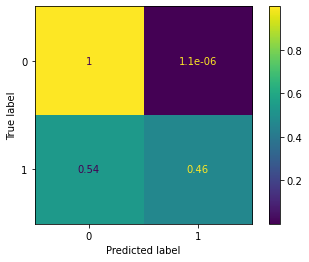

In [27]:
plot_confusion_matrix(lr, x_teste, y_teste, normalize='true')
plt.show()

### 4.1.2 - Dados Balanceados

In [28]:
lr = LogisticRegression(max_iter=1500)

In [29]:
lr.fit(x_treino_balanceado, y_treino_balanceado)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
lr.score(x_treino_balanceado, y_treino_balanceado)

0.9477892756349953

In [31]:
lr.score(x_teste_balanceado, y_teste_balanceado)

0.935503992015968

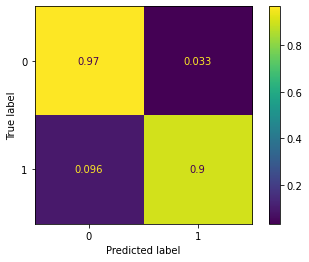

In [32]:
plot_confusion_matrix(lr, x_teste_balanceado, y_teste_balanceado, normalize='true')
plt.show()

In [33]:
lr.score(x_teste, y_teste)

0.969701160842546

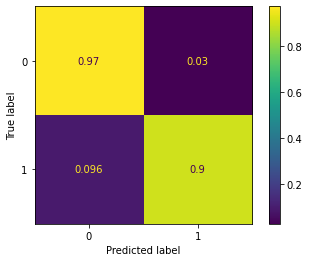

In [34]:
plot_confusion_matrix(lr, x_teste, y_teste, normalize='true')
plt.show()